In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose

In [6]:
data = pd.read_pickle('../00_Data/data_full_with_holiday.pkl')

In [7]:
data_train = data.loc[data.index < '2023-10-30']
data_test = data.loc[data.index >= '2023-10-30']

In [8]:
X_train = data_train.drop('demand', axis=1)
X_test = data_test.drop('demand', axis=1)

y_train = data_train['demand']
y_train.name = 'Actual demand (train)'
y_test = data_test['demand']
y_test.name = 'Actual demand (test)'

# Model Implementation

In [9]:
import pmdarima as pm

In [28]:
decomposed = seasonal_decompose(y_train, model='additive', period=48)

trend = decomposed.trend
seasonal = decomposed.seasonal
residuals = decomposed.resid

In [29]:
mean_residual = residuals.dropna().mean()
residuals_imputed = residuals.fillna(mean_residual)

In [30]:
arima_model = pm.auto_arima(residuals_imputed, test='adf', seasonal=False,
                      trace=True, error_action='ignore',  
                      suppress_warnings=True, stepwise=True)

print(arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=753247.468, Time=6.68 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=914189.229, Time=0.29 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=777130.243, Time=0.38 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=852966.498, Time=5.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=757271.508, Time=9.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=753259.253, Time=2.74 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=753022.660, Time=14.00 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=26.85 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=inf, Time=37.92 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=37.16 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=25.93 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=753017.473, Time=19.42 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=753268.613, Time=2.21 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=753018.268, Time=24.76 sec
 ARIMA(3,0,0)(0,0,0)[0]   

In [31]:
arima_model.fit(y_train)

ARIMA(order=(4, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

## Prediction

In [46]:
resid_pred = arima_model.predict(len(X_test))

last_trend_value = trend.dropna().iloc[-1]
trend_pred = pd.Series([last_trend_value] * len(X_test), index=X_test.index)

seasonal_pred = pd.Series(index=X_test.index, dtype=float)
for i in range(len(X_test)):
    # Find the index for the seasonal component 48 periods ago
    idx = (i - 48) % 48
    seasonal_pred.iloc[i] = seasonal.iloc[idx]

In [47]:
full_pred = resid_pred + trend_pred + seasonal_pred

## Prediction Statistics

In [50]:
y_pred_s = pd.Series(full_pred, index=y_test.index, name='Predicted demand (test)')

### 24 Hours Forecast

In [51]:
y_pred_48 = y_pred_s.iloc[:48]
y_test_48 = y_test.iloc[:48]

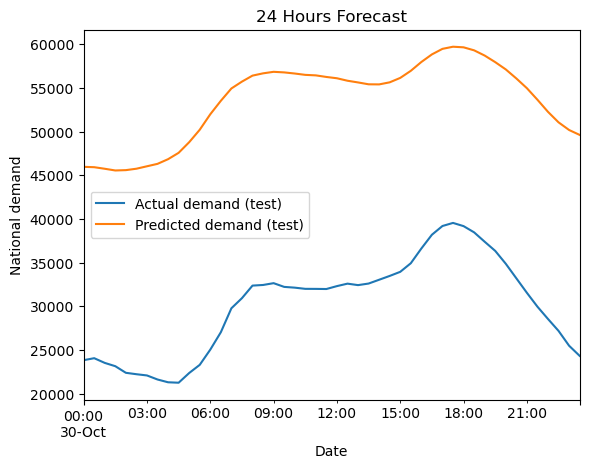

In [52]:
fig, ax = plt.subplots()
y_test_48.plot(ax=ax)
y_pred_48.plot(ax=ax)
ax.legend()
ax.set_title('24 Hours Forecast')
ax.set_xlabel("Date")
ax.set_ylabel("National demand")
plt.show()

In [53]:
print(f'RMSE for 24 hours: {mean_squared_error(y_test_48, y_pred_48, squared=False)}')

RMSE for 24 hours: 23523.602681694698


### 7 Days Prediction

In [54]:
y_pred_336 = y_pred_s.iloc[:336]
y_test_336 = y_test.iloc[:336]

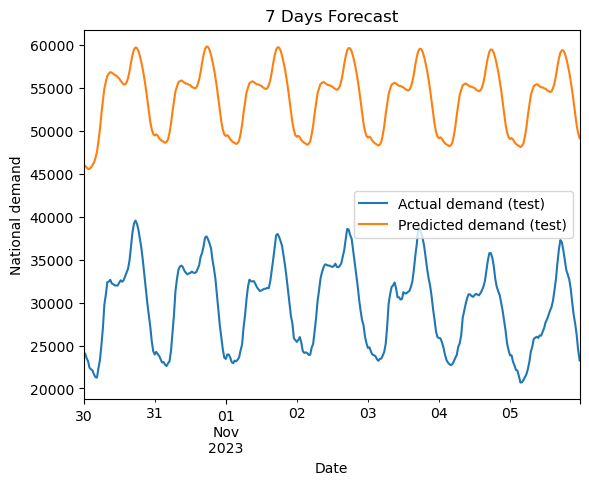

In [55]:
fig, ax = plt.subplots()
y_test_336.plot(ax=ax)
y_pred_336.plot(ax=ax)
ax.legend()
ax.set_title('7 Days Forecast')
ax.set_xlabel("Date")
ax.set_ylabel("National demand")
plt.show()

In [56]:
print(f'RMSE for 7 days: {mean_squared_error(y_test_336, y_pred_336, squared=False)}')

RMSE for 7 days: 24169.245687962837


### 28 Days Prediction

In [57]:
y_pred_1344 = y_pred_s.iloc[:1344]
y_test_1344 = y_test.iloc[:1344]

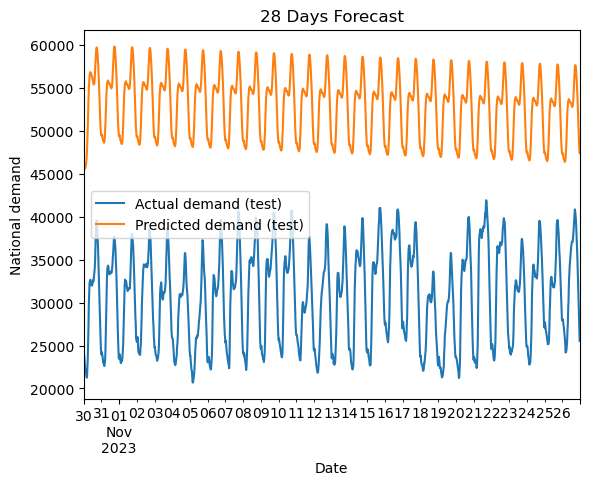

In [58]:
fig, ax = plt.subplots()
y_test_1344.plot(ax=ax)
y_pred_1344.plot(ax=ax)
ax.legend()
ax.set_title('28 Days Forecast')
ax.set_xlabel("Date")
ax.set_ylabel("National demand")
plt.show()

In [59]:
print(f'RMSE for 28 days: {mean_squared_error(y_test_1344, y_pred_1344, squared=False)}')

RMSE for 28 days: 22445.12908174389
